# Data Science Personal Project

## Dataset used:
> Covid Tracking Data 

## AIM: 
> To help analyse current COVID situation in different states by means of relevant visualizations.

> To predict useful variables such as new cases, active cases, deaths, hospitalizations, probability of an individual getting COVID, etc. to help the state governments, testing agencies, hospitals and individuals during the pandemic.

# Practiced by
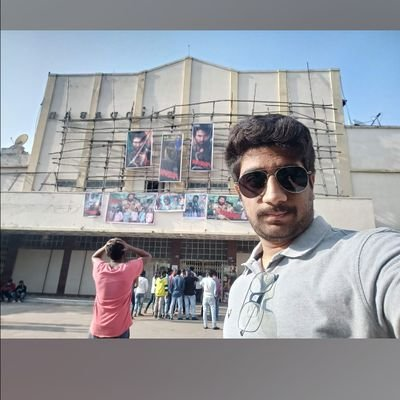


#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

#### Storing the dataset as a Pandas Dataframe

In [2]:
CovidData = pd.read_csv('Historic+Current values for all states.csv')
CovidData.head()

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210307,AK,56886.0,NaN,NaN,NaN,totalTestsViral,1731628.0,33.0,1293.0,...,NaN,0,0,dc4bccd4bb885349d7e94d6fed058e285d4be164,0,0,0,0,0,NaN
1,20210307,AL,499819.0,107742.0,1931711.0,NaN,totalTestsPeopleViral,2323788.0,494.0,45976.0,...,NaN,-1,0,997207b430824ea40b8eb8506c19a93e07bc972e,0,0,0,0,0,NaN
2,20210307,AR,324818.0,69092.0,2480716.0,NaN,totalTestsViral,2736442.0,335.0,14926.0,...,NaN,22,11,50921aeefba3e30d31623aa495b47fb2ecc72fae,0,0,0,0,0,NaN
3,20210307,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,...,NaN,0,0,96d23f888c995b9a7f3b4b864de6414f45c728ff,0,0,0,0,0,NaN
4,20210307,AZ,826454.0,56519.0,3073010.0,NaN,totalTestsViral,7908105.0,963.0,57907.0,...,NaN,5,44,0437a7a96f4471666f775e63e86923eb5cbd8cdf,0,0,0,0,0,NaN


##### Importing US Statewise population

In [3]:
StateWisePopulation = pd.read_csv('US Statewise Population.csv')
StateWisePopulation.head()

,state,Current Population
0,AK,731545
1,AL,4903185
2,AR,3017825
3,AS,55641
4,AZ,7278717


## Data Cleaning and Data Merging 

### Data Frame only containing relevant variables

In [4]:
CovidUseful= pd.DataFrame(CovidData[["date","state","positive","recovered","death",
                                     "positiveTestsPeopleAntibody","positiveIncrease","deathIncrease","hospitalizedIncrease",
                                    "totalTestResultsIncrease","hospitalized", "totalTestResults","positiveCasesViral"]])


### Setting the NaN values in the data to zero

In [5]:
CovidUseful= CovidUseful.replace(np.nan, 0)

### Converting "date" from string to a datetime object

In [6]:
CovidUseful['date'] =  pd.to_datetime(CovidUseful['date'], format='%Y%m%d')

### Grouping Data according to states

In [7]:
StatewiseData = CovidUseful.groupby(["state"])

### Function to obtain data frame for each state

In [8]:
def StateDataFrame(StatewiseData, state):
             return StatewiseData.get_group(state).reset_index(drop=True)

In [9]:
Ak=StateDataFrame(StatewiseData, 'AK')
Ak.head()

,date,state,positive,recovered,death,positiveTestsPeopleAntibody,positiveIncrease,deathIncrease,hospitalizedIncrease,totalTestResultsIncrease,hospitalized,totalTestResults,positiveCasesViral
0,2021-03-07,AK,56886.0,0.0,305.0,0.0,0,0,0,0,1293.0,1731628.0,0.0
1,2021-03-06,AK,56886.0,0.0,305.0,0.0,0,0,0,0,1293.0,1731628.0,0.0
2,2021-03-05,AK,56886.0,0.0,305.0,0.0,141,2,3,7144,1293.0,1731628.0,0.0
3,2021-03-04,AK,56745.0,0.0,303.0,0.0,140,0,5,13466,1290.0,1724484.0,0.0
4,2021-03-03,AK,56605.0,0.0,303.0,0.0,177,1,-1,6358,1285.0,1711018.0,0.0


## Data Curation 
> Making custom functions used in Exploratory Data Analysis ( EDA ) 

### Function to compute fatality ratio

In [10]:
def fatality_ratio(state):
    """
    Computes the fatality ratio for the given state
    Fatality ratio is the ratio of total dead to total positive case
    """
    
    date = CovidData.iloc[0]['date']
    try:
        d = float(CovidData[(CovidData['state']==state) & (CovidData['date']==date)]['death'])
        p = float(CovidData[(CovidData['state']==state) & (CovidData['date']==date)]['positive'])
    except:
        print("Could not retrieve the necessary information")
    
    if (d!=-1.0) and (p!=-1.0) and (p!=0):
        return round(d/p,3)
    else:
        return -1

### Function to compute hospitalization ratio

In [11]:
def hospitalization_ratio(state):
    """
    Computes the hospitalization ratio for the given state
    Hospitalization ratio is the ratio of total hospitalized to total positive case
    """
    
    date = CovidData.iloc[0]['date']
    try:
        h = float(CovidData[(CovidData['state']==state) & (CovidData['date']==date)]['hospitalized'])
        p = float(CovidData[(CovidData['state']==state) & (CovidData['date']==date)]['positive'])
    except:
        print("Could not retrieve the necessary information")
    
    if (h!=-1.0) and (p!=-1.0) and (p!=0):
        return round(h/p,3)
    else:
        return -1

### Function to compute positive case/total test ratio

In [12]:
def positiveTest_ratio(state):
    """
    Computes the test-positive ratio for the given state
    Test-positive ratio is the ratio of total positive cases to total number of tests
    """
    
    date = CovidData.iloc[0]['date']
    try:
        p = float(CovidData[(CovidData['state']==state) & (CovidData['date']==date)]['positive'])
        t = float(CovidData[(CovidData['state']==state) & (CovidData['date']==date)]['totalTestResults'])
    except:
        print("Could not retrieve the necessary information")
        return -1
    
    if (p!=-1.0) and (t!=-1.0) and (t!=0):
        return round(p/t,3)
    else:
        return -1

### Function to calculate recovery ratio

In [13]:
def recovery_ratio(state):
    """
    Computes the recovery ratio for the given state
    Recovery ratio is the ratio of total recovered cases to total positive cases
    """
    
    date = CovidData.iloc[0]['date']
    try:
        r = float(CovidData[(CovidData['state']==state) & (CovidData['date']==date)]['recovered'])
        p = float(CovidData[(CovidData['state']==state) & (CovidData['date']==date)]['positive'])
    except:
        print("Could not retrieve the necessary information")
        return -1
    
    if (r!=-1.0) and (p!=-1.0) and (p!=0):
        return round(r/p,3)
    else:
        return -1

### Function to calculate daily population

##### Calculating daily growth in population
> considering daily births, deaths and migration 

In [14]:
DailyGrowth = 1*24*60*60/40

##### function that creates a new column in a state's data frame of the daily population

In [15]:
def addPopulation(StateWisePopulation, StatewiseData, state):
  stateDF=StateDataFrame(StatewiseData, state)
  stateDF['DailyPopulation']=StateWisePopulation[StateWisePopulation['state'] == state]['Current Population'].values[0]
  stateDF.at[0,'DailyPopulation']=stateDF.at[0,'DailyPopulation']-stateDF.at[0,'deathIncrease']
  for i in range(1,len(stateDF['date'])):
    stateDF.at[i,'DailyPopulation']= stateDF.at[i-1,'DailyPopulation']+DailyGrowth-stateDF.at[i,'deathIncrease']
  return stateDF

### Function to calculate number of people who have antibodies and immunity against covid currently 

##### function that creates a new column in a state's data frame of the people who have antibodies currently
> according to CDC, antibodies and immunity against COVID officially lasts for 3 months (90 days) on average

In [16]:
def addAntibodies(stateDF, state):
  stateDF['positiveAntibodiesIncrease']=stateDF['positiveTestsPeopleAntibody']
  for k in range(len(stateDF['date'])-1, 0, -1):
    stateDF.at[k,'positiveAntibodiesIncrease']= stateDF.at[k,'positiveTestsPeopleAntibody']-stateDF.at[k-1,'positiveTestsPeopleAntibody']
  stateDF['immunisedPopulation']=stateDF['positiveAntibodiesIncrease']
  for i in range(0,len(stateDF['date'])):
    for j in range(1, 90):
      if (i-j)>=0:
        temp= stateDF.at[i-j,'positiveAntibodiesIncrease']
        stateDF.at[i,'immunisedPopulation']= stateDF.at[i,'immunisedPopulation']+temp
      else:
        break      
  return stateDF

### Function to calculate number of people currently infected with covid (active cases)

##### function that creates a new column in a state's data frame of the people who have covid currently 

In [17]:
def addCurrentlyInfected (stateDF, state):
 stateDF['activeCases']= stateDF['positive'] - stateDF['recovered'] - stateDF['death']
 return stateDF

### Function to calculate the probability of a person getting covid on a particular day 

##### function that creates a new column in a state's data frame of the probability of a person getting COVID on that day
>Probabilty of a person getting covid on a particular day= No. of positive cases on that day/No. of people who can have COVID on that day
Probabilty of a person getting covid on a particular day= No. of positive cases on that day/(Population on that day - People who have antibodies on that day - Active cases on that day)

In [18]:
def findProbability(StatewisePopulation,StateWiseData,state):
  stateDF = addPopulation( StateWisePopulation, StatewiseData, state)
  stateDF= addAntibodies(stateDF, state)
  stateDF= addCurrentlyInfected(stateDF, state)
  stateDF['peopleWhoCanGetCOVID']=stateDF['DailyPopulation']-stateDF['immunisedPopulation']-stateDF['activeCases']
  stateDF['probabilityOfGettingCOVID']=stateDF['positiveIncrease']/stateDF['peopleWhoCanGetCOVID']
  return stateDF

AlaskaDF=findProbability(StateWisePopulation,StatewiseData, 'AK')
AlaskaDF.head()

,date,state,positive,recovered,death,positiveTestsPeopleAntibody,positiveIncrease,deathIncrease,hospitalizedIncrease,totalTestResultsIncrease,hospitalized,totalTestResults,positiveCasesViral,DailyPopulation,positiveAntibodiesIncrease,immunisedPopulation,activeCases,peopleWhoCanGetCOVID,probabilityOfGettingCOVID
0,2021-03-07,AK,56886.0,0.0,305.0,0.0,0,0,0,0,1293.0,1731628.0,0.0,731545,0.0,0.0,56581.0,674964.0,0.000000
1,2021-03-06,AK,56886.0,0.0,305.0,0.0,0,0,0,0,1293.0,1731628.0,0.0,733705,0.0,0.0,56581.0,677124.0,0.000000
2,2021-03-05,AK,56886.0,0.0,305.0,0.0,141,2,3,7144,1293.0,1731628.0,0.0,735863,0.0,0.0,56581.0,679282.0,0.000208
3,2021-03-04,AK,56745.0,0.0,303.0,0.0,140,0,5,13466,1290.0,1724484.0,0.0,738023,0.0,0.0,56442.0,681581.0,0.000205
4,2021-03-03,AK,56605.0,0.0,303.0,0.0,177,1,-1,6358,1285.0,1711018.0,0.0,740182,0.0,0.0,56302.0,683880.0,0.000259


## Exploratory Data Analysis ( EDA )

## Scatter Plots 

### Function to create scatter plot of two variables for a given state

In [19]:
def plot_xy(varx,vary,state):
    """
    Plots a bar chart of the given variable over the date range
    """
    assert type(varx)==str, "Expected string as the variable x name"
    assert type(vary)==str, "Expected string as the variable y name"
 
    y = CovidData[CovidData['state']==state][vary]
    x = CovidData[CovidData['state']==state][varx]
    if (x.nunique()!=1) and (y.nunique()!=1):
        plt.figure(figsize=(12,4))
        plt.title("Plot of \"{}\" vs. \"{}\" for {}".format(varx,vary,state),fontsize=18)
        plt.scatter(x=x,y=y,edgecolor='k',color='lightgreen',s=100)
        plt.grid(True)
        plt.xticks(fontsize=14,rotation=45)
        plt.yticks(fontsize=14)
        plt.show()
    else:
        print("Some of the data unavailable for a scatter plot. Sorry!")

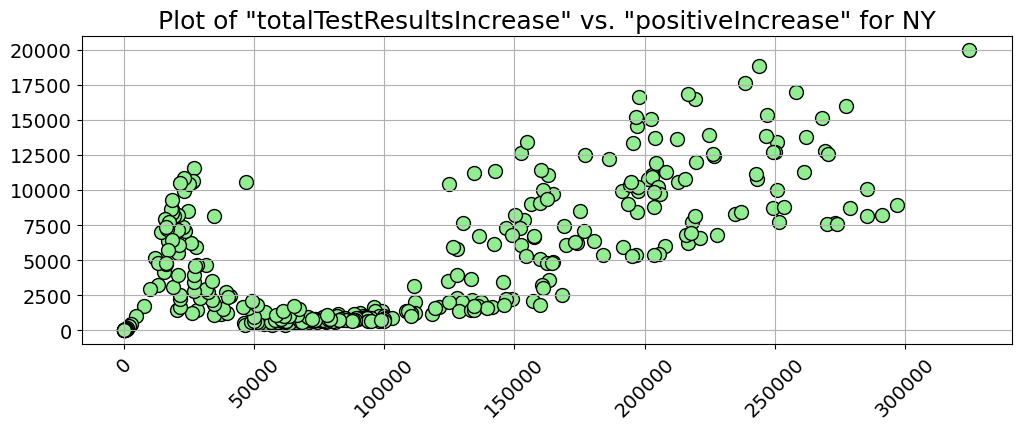

In [20]:
plot_xy('totalTestResultsIncrease','positiveIncrease','NY')

#### We can see that there is a moderate positive relationship between increase in total testing and increase in positive cases in NY.

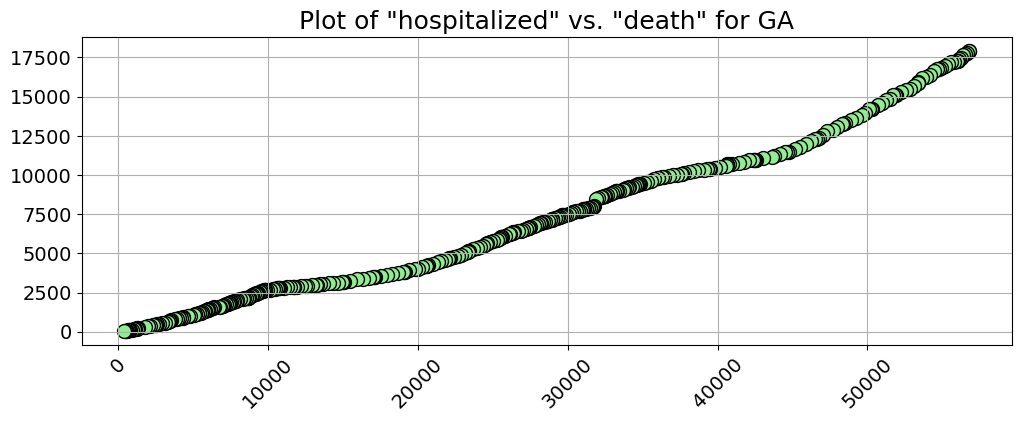

In [21]:
plot_xy('hospitalized','death','GA')

#### We can see that there is a very strong linear correlation between number of people hospitalized and number of people dying because of COVID in GA.

### Testing tracker function
> Testing is crucially important to track the spread of the virus and contain it. Let us see how states the doing on this aspect relatively.

In [22]:
def plotTesting(lst_states=['NY','CA','MA','TX','PA']):
   
    """
    Plots the cumulative testing done by the given list of states
    """
    legends = []
    plt.figure(figsize=(10,5))
    plt.title("Total test results",fontsize=18)
    for s in lst_states:
        data = np.array(CovidData[CovidData['state']==s]['totalTestResults'])[-1::-1]
        slope = int((data[-1]-data[0])/len(data))
        plt.plot(data,linewidth=2)
        plt.text(x=len(data)-2,y=data[-1]*1.05,s=s,fontsize=14)
        legends.append(str(slope)+" tests/day in " + s)
    plt.legend(legends,fontsize=14)
    plt.grid(True)
    plt.xlim(0,len(data)+2)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Days",fontsize=16)
    plt.ylabel("Total test results",fontsize=16)
    plt.show()

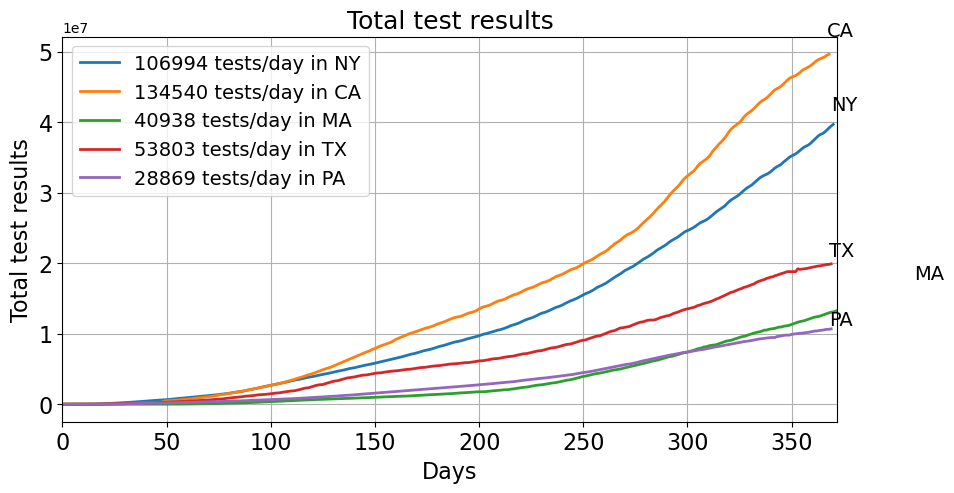

In [23]:
plotTesting()

#### CA has the highest testing rate whereas PA has the lowest testing rate among the chosen states.

### Hospitalization chart

> The next hospitalization rate chart is tried for the same set of states but only two of them reports proper data. Therefore, the code plots the chart only for those states.

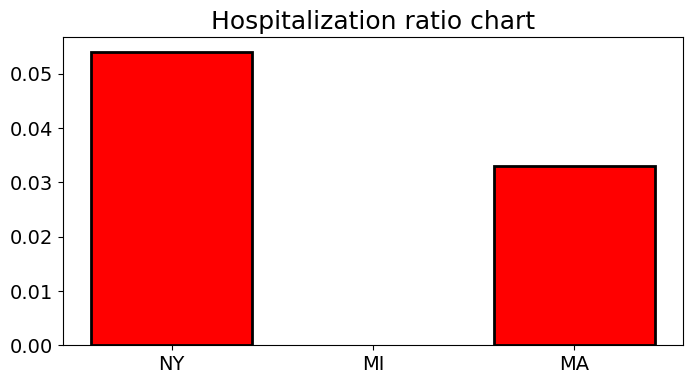

In [24]:
states = ['CA','NY','MI','MA','PA','IL']
hos,x = [],[]
for s in states:
    data = hospitalization_ratio(s)
    if data!=-1:
        hos.append(data)
        x.append(s)
plt.figure(figsize=(8,4))
plt.title("Hospitalization ratio chart",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.bar(x=x,height=hos,color='red',
        edgecolor='k',linewidth=2)
plt.show()

#### We note that NY has a much higher hospitalization ratio than MA.

### Test-positive ratio chart

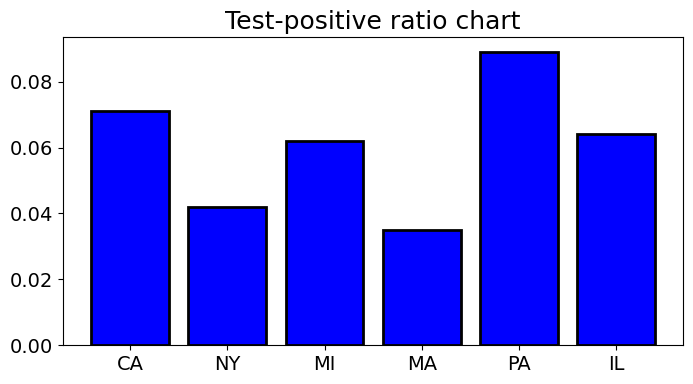

In [25]:
states = ['CA','NY','MI','MA','PA','IL']
tp,x = [],[]
for s in states:
    data = positiveTest_ratio(s)
    if data!=-1:
        tp.append(data)
        x.append(s)
plt.figure(figsize=(8,4))
plt.title("Test-positive ratio chart",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.bar(x=x,height=tp,color='blue',
        edgecolor='k',linewidth=2)
plt.show()

#### We note that most people who get tested turn out to be COVID positive in PA, and least in MA among the chosen states.

## Bubble Charts

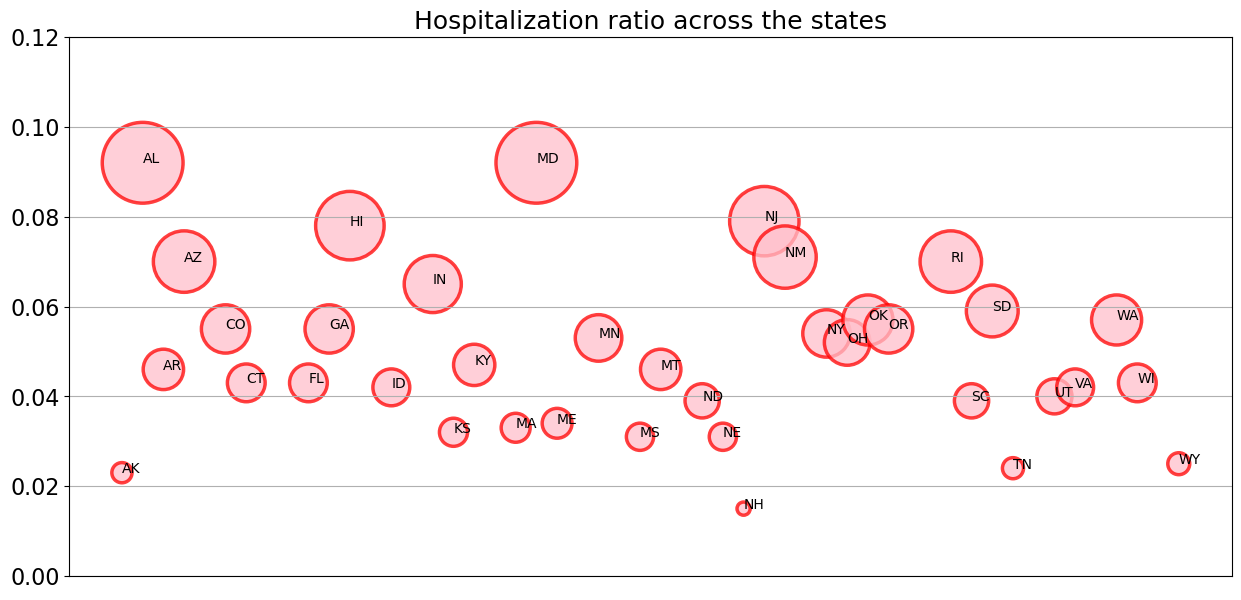

In [26]:
states = list(CovidData['state'].unique())
for s in ['AS','GU','MP','PU','VI']:
    try:
        states.remove(s)
    except:
        pass

fr,x = [],[]
for s in states:
    data = hospitalization_ratio(s)
    if data!=-1:
        fr.append(data)
        x.append(s)
fr = np.array(fr)
plt.figure(figsize=(15,7))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.title("Hospitalization ratio across the states",fontsize=18)
plt.scatter(x=x,y=fr,
            s=4e5*fr**2,
            color='pink',edgecolor='red',alpha=0.75,linewidth=2.5)
#plt.xticks(rotation=45,fontsize=12)
for i,s in enumerate(x):
    plt.annotate(text=s,xy=(x[i],fr[i]))
plt.ylim(0,0.12)
plt.yticks(fontsize=16)
plt.grid(True,axis='y')
plt.show()

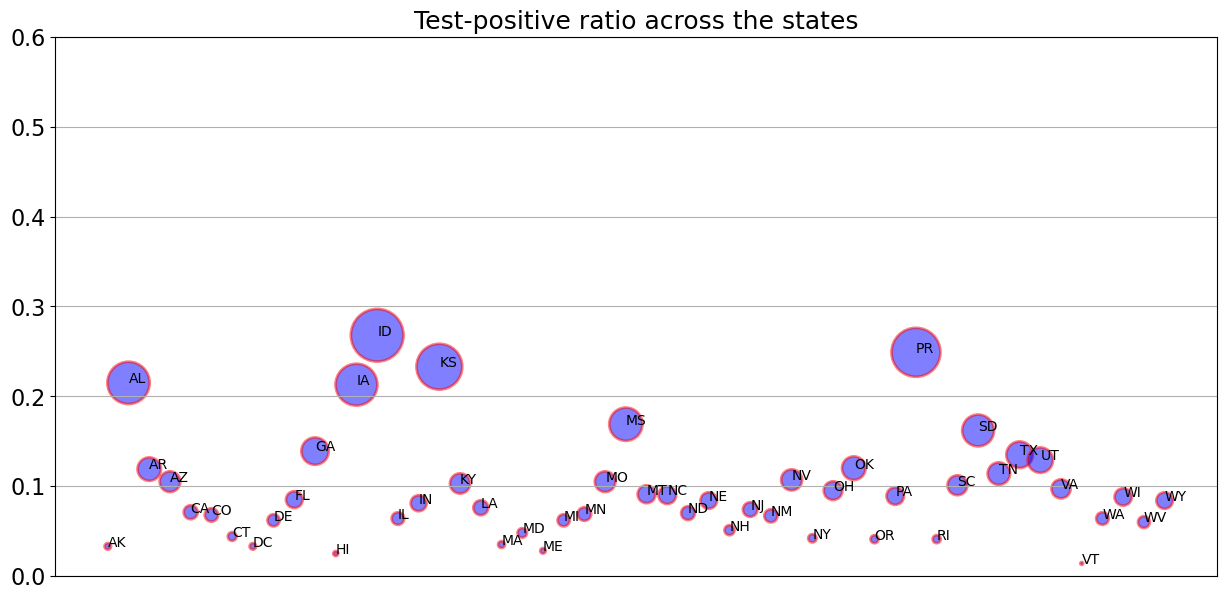

In [27]:
states = list(CovidData['state'].unique())
for s in ['AS','GU','MP','PU','VI']:
    try:
        states.remove(s)
    except:
        pass

tp,x = [],[]
for s in states:
    data = positiveTest_ratio(s)
    if data!=-1:
        tp.append(data)
        x.append(s)
tp = np.array(tp)
plt.figure(figsize=(15,7))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.title("Test-positive ratio across the states",fontsize=18)
plt.scatter(x=x,y=tp,
            s=2e4*tp**2,
            color='blue',edgecolor='red',alpha=0.5,linewidth=2)
plt.xticks(rotation=90,fontsize=12)
for i,s in enumerate(x):
    plt.annotate(text=s,xy=(x[i],tp[i]))
plt.ylim(0,0.6)
plt.yticks(fontsize=16)
plt.grid(True,axis='y')
plt.show()

## COVID Statistics for entire US

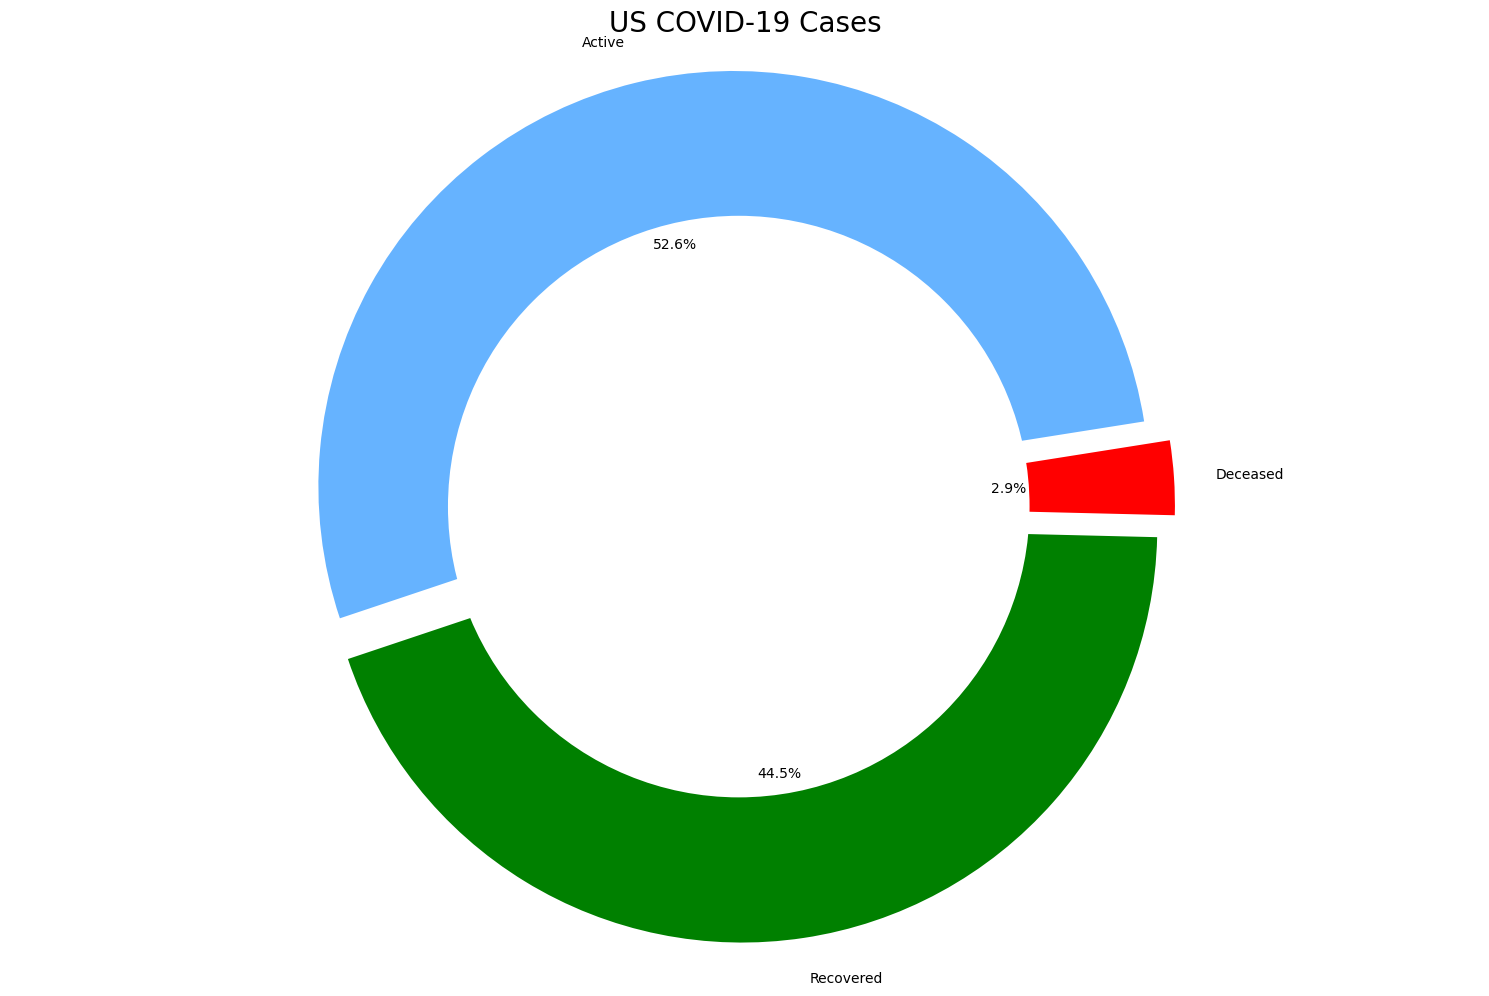

In [28]:
confirmed_total = int(CovidUseful['positiveCasesViral'].sum())
deaths_total = int(CovidUseful['death'].sum())
recovered_total = int(CovidUseful['recovered'].sum())

active_cases = confirmed_total - (recovered_total + deaths_total)

labels = ['Active','Recovered','Deceased']
sizes = [active_cases,recovered_total,deaths_total]
color= ['#66b3ff','green','red']
explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('US COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()


## Heatmap showing COVID statistics for each state

In [29]:
state_cases = StatewiseData['positiveCasesViral','death','recovered'].max().reset_index()

state_cases['Active'] = state_cases['positiveCasesViral'] - (state_cases['death']+state_cases['recovered'])
state_cases.sort_values('positiveCasesViral', ascending= False).fillna(0).style.background_gradient(cmap='Oranges',subset=["positiveCasesViral"])\
                        .background_gradient(cmap='Oranges',subset=["death"])\
                        .background_gradient(cmap='Oranges',subset=["recovered"])\
                        .background_gradient(cmap='Oranges',subset=["Active"])

,state,positiveCasesViral,death,recovered,Active
5,CA,3501394.000000,54124.000000,0.000000,3447270.000000
47,TX,2320857.000000,44451.000000,2502609.000000,-226203.000000
10,FL,1548837.000000,32266.000000,0.000000,1516571.000000
38,OH,836358.000000,17656.000000,925655.000000,-106953.000000
11,GA,828336.000000,17906.000000,0.000000,810430.000000
41,PA,814540.000000,24349.000000,861756.000000,-71565.000000
4,AZ,769935.000000,16328.000000,0.000000,753607.000000
30,NC,759617.000000,11502.000000,0.000000,748115.000000
34,NJ,720939.000000,23574.000000,0.000000,697365.000000
46,TN,653905.000000,11543.000000,756793.000000,-114431.000000


### Bar Charts

#### Function to plot a bar chart of the given variable/state

In [30]:
def plot_var(var,state):
    """
    Plots a bar chart of the given variable over the date range
    """
    assert type(var)==str, "Expected string as the variable name"
    assert type(state)==str, "Expected string as the state name"
 
    y = CovidUseful[CovidUseful['state']==state][var]
    x = CovidUseful[CovidUseful['state']==state]['date']
    plt.figure(figsize=(12,4))
    plt.title("Plot of \"{}\" for {}".format(var,state),fontsize=18)
    plt.bar(x=x,height=y,edgecolor='k',color='orange')
    plt.grid(True)
    plt.xticks(fontsize=14,rotation=45)
    plt.yticks(fontsize=14)
    plt.show()

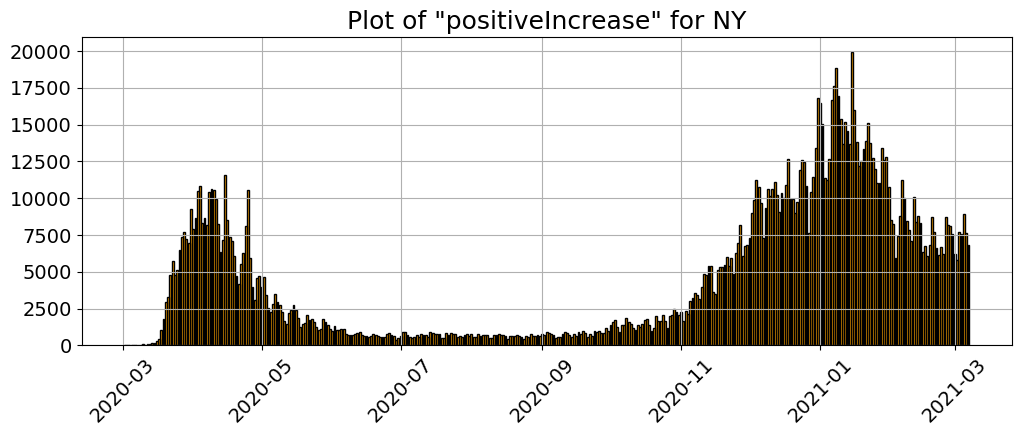

In [31]:
plot_var('positiveIncrease','NY')

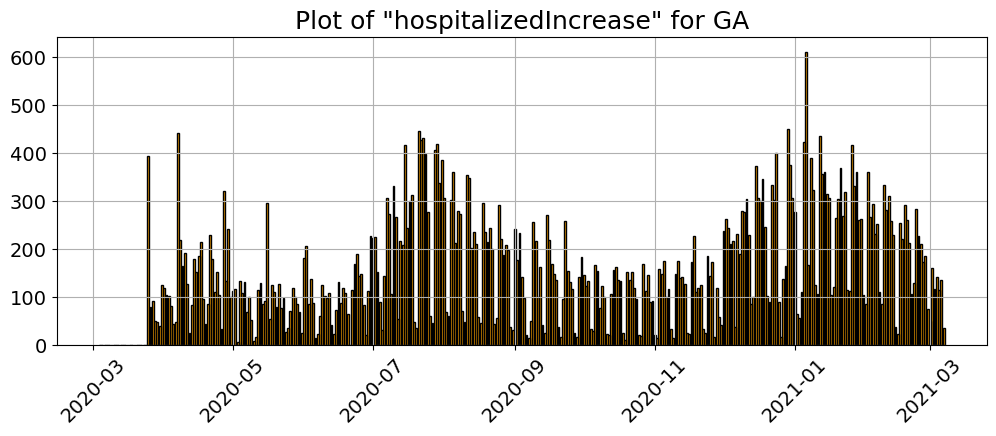

In [32]:
plot_var('hospitalizedIncrease','GA')

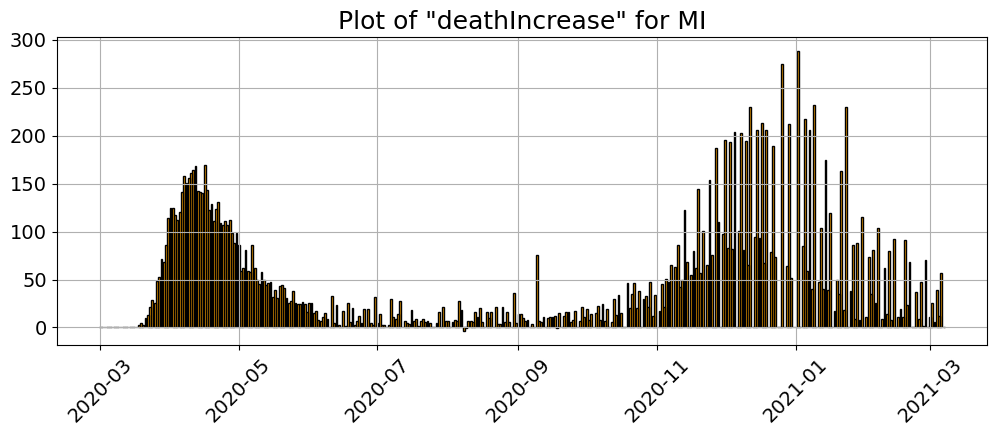

In [33]:
plot_var('deathIncrease','MI')

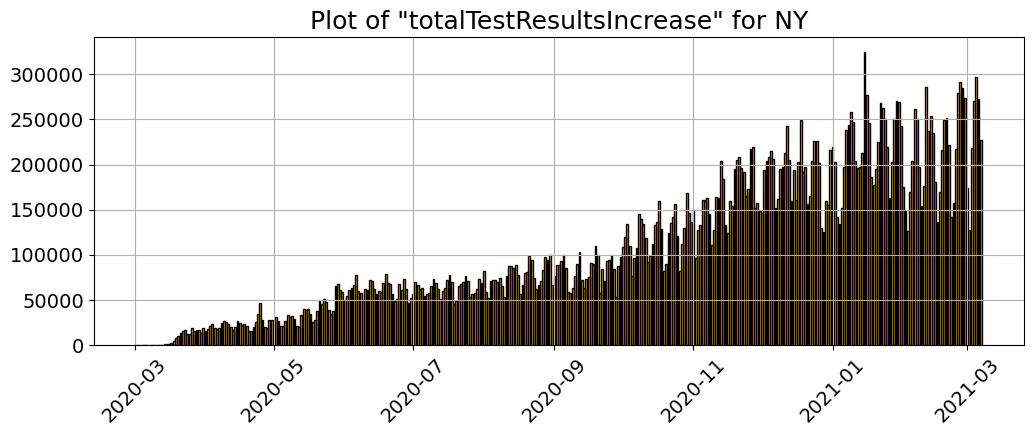

In [34]:
plot_var('totalTestResultsIncrease','NY')

### From these bar plots, we can see that various variables such as daily increase in positive cases, number of people hospitalized, daily deaths due to COVID and total number of people getting tested vary considerably with time, and follow significantly observable patterns in most cases. Hence, we decided to predict such variable for each state for the next 15 days (short run) so that the state governments, testing agencies, hospitals, etc. can prepare for the upcoming situation in advance and take action accordingly.

## Predicting future values for next 15 days

### 1. Using average growth factor 

>We assume that the average growth rate of the variable is constant

In [35]:
def averageGrowthFactorPrediction(state, value):
    
    stateDF=findProbability(StateWisePopulation,StatewiseData, state)
    stateDF= stateDF.iloc[::-1]
    stateDF = stateDF.reset_index(drop=True)

    k =stateDF[value].loc[:]
    state_value = k.values.tolist()
    growth_diff = []

    for i in range(1,len(state_value)):
        if(state_value[i-1]!=0):
            growth_diff.append(state_value[i] / state_value[i-1])

    growth_factor = sum(growth_diff)/len(growth_diff)
    print('Average growth factor',growth_factor)
    
    
    #prediction
    
    prediction_dates = []

    start_date = stateDF['date'][len(stateDF['date']) - 1]
    for i in range(15):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date
    
    previous_day_value = stateDF[value][len(stateDF['date']) - 1]


    predicted_cases = []

    for i in range(15):
        predicted_value = previous_day_value *  growth_factor
        predicted_cases.append(predicted_value)
        previous_day_value = predicted_value

    plt.figure(figsize= (10,7))
    plt.xticks(rotation = 90 ,fontsize = 11)
    plt.yticks(fontsize = 10)
    plt.xlabel("Dates",fontsize = 20)
    plt.ylabel(value,fontsize = 20)
    plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
    ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')
    
    return
    
    

Average growth factor 1.0325617183776112


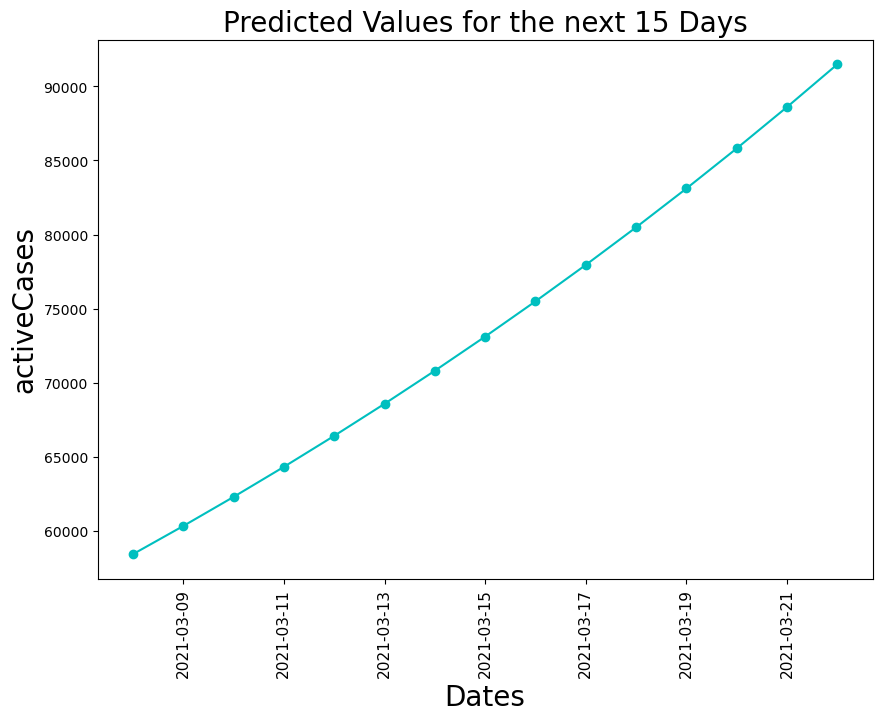

In [36]:
averageGrowthFactorPrediction('AK', 'activeCases')

### 2. Using ARIMA Model - To forecast future values

ARIMA stands for Auto-Regressive Integrated Moving Averages. It is a machine learning technique that is used to provide accurate predictions for a time series in the short run.

#### i. Converting data to a time series 

##### function to convert the generated date-probability dataframe into a series

In [37]:
def series(stateDF):
    stateDF.drop(['state'], axis=1)
    stateDF= stateDF.set_index('date')
    TS=stateDF[['probabilityOfGettingCOVID']].squeeze()
    return TS

In [38]:
AlaskaTS= series(AlaskaDF)
print(AlaskaTS)
print(type(AlaskaTS))

date
2021-03-07    0.000000
2021-03-06    0.000000
2021-03-05    0.000208
2021-03-04    0.000205
2021-03-03    0.000259
                ...   
2020-03-10    0.000000
2020-03-09    0.000000
2020-03-08    0.000000
2020-03-07    0.000000
2020-03-06    0.000000
Name: probabilityOfGettingCOVID, Length: 367, dtype: float64
<class 'pandas.core.series.Series'>


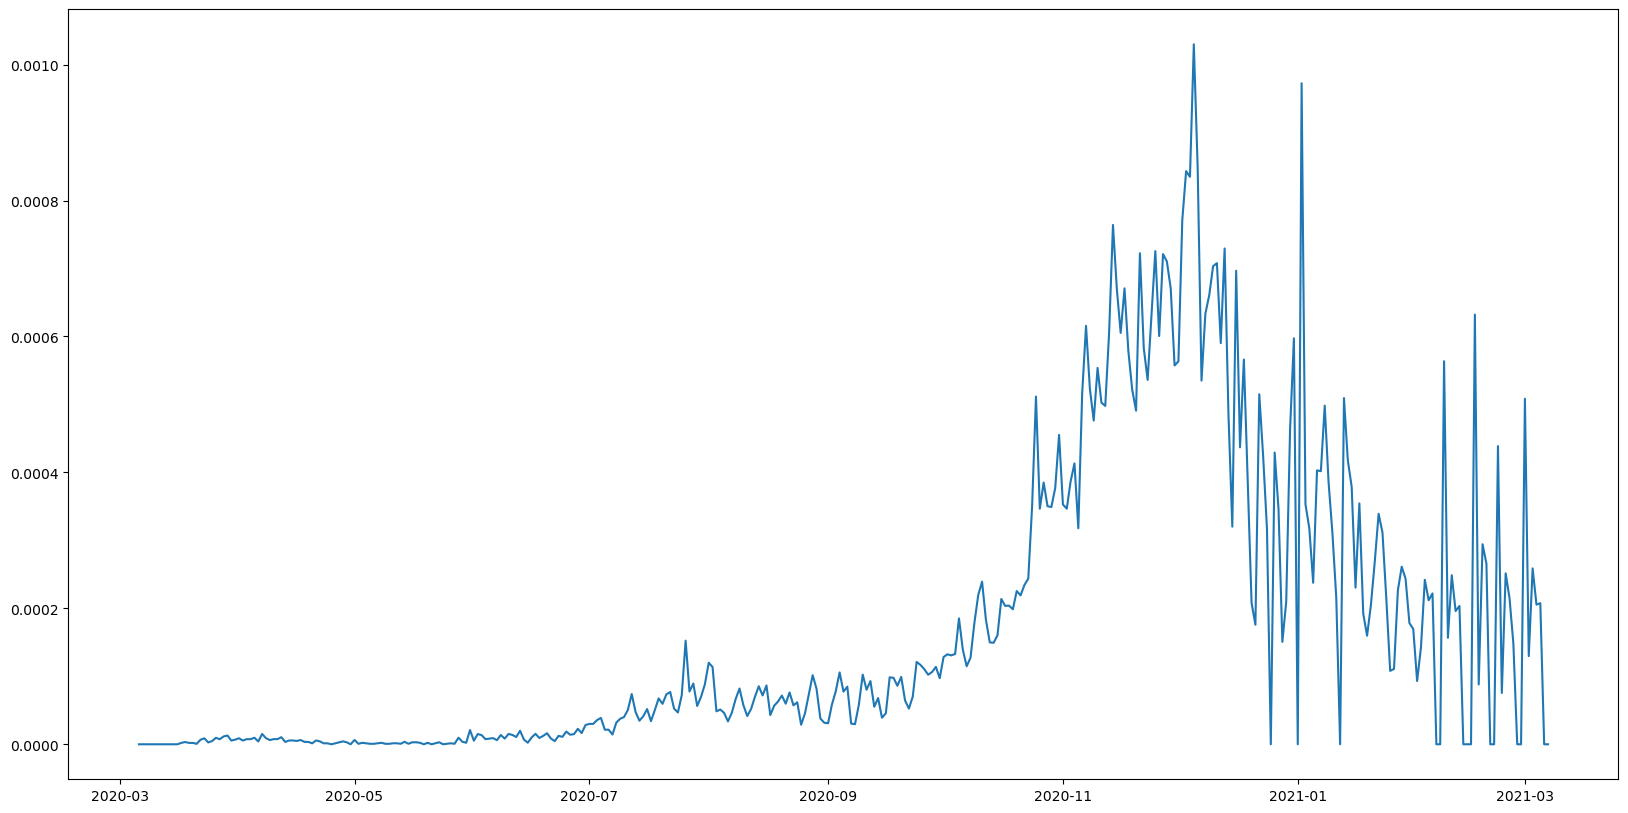

In [39]:
f = plt.figure(figsize = (20,10))
plt.plot(AlaskaTS)

#### ii. Checking stationarity of a time series 
> A stationary series is one in which the properties – mean, variance and covariance, do not vary with time.

> Plotting rolling statistics

> Dickey Fuller Test

> KPSS Test

In [40]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    f = plt.figure(figsize = (15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    print()
    
    #Perform KPSS test
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
    return

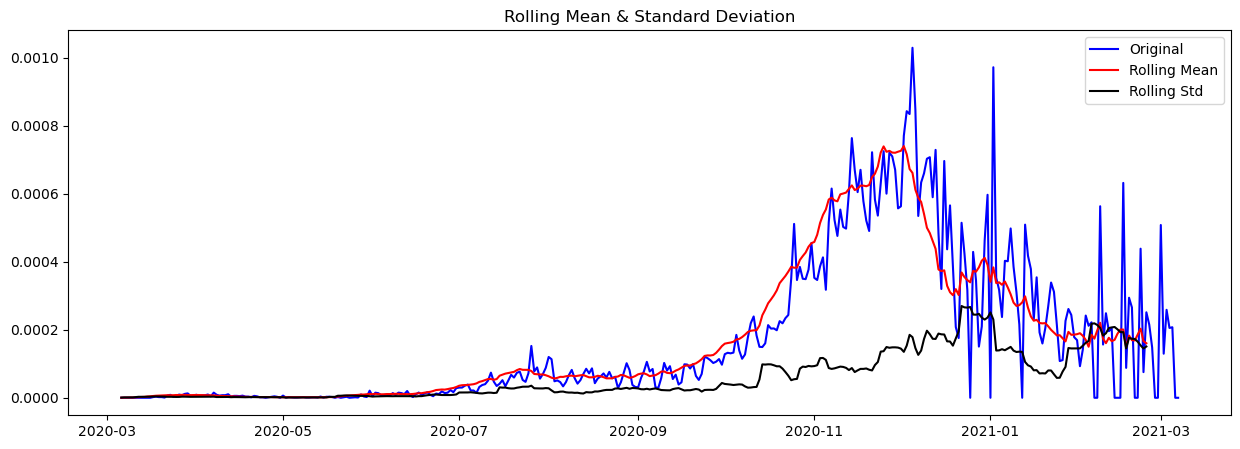

Results of Dickey-Fuller Test:
Test Statistic                  -1.254630
p-value                          0.649665
#Lags Used                      12.000000
Number of Observations Used    354.000000
Critical Value (1%)             -3.448958
Critical Value (5%)             -2.869739
Critical Value (10%)            -2.571138
dtype: float64

Results of KPSS Test:
Test Statistic            1.711653
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [41]:
test_stationarity(AlaskaTS)

##### Since the Test Statistic of Dickey-Fuller Test is bigger than all the critical values we cannot say that the time series is stationary.
##### Hence, we have to make the time series stationary to make predictions on it

#### iii. Making the time series stationary
>1. By eliminating trends

>2. By eliminating noise

>3. By eliminating seasonality

In [42]:
def stationarizing(timeseries):
    
    #estimating and eliminating trend
    ts_log = np.log(timeseries)
    np.seterr(divide = 'ignore')
    ts_log.replace([np.inf, -np.inf], np.nan, inplace=True)
    ts_log= ts_log.replace(np.nan,0)
    
    #smoothening to eliminate noise
    moving_avg = ts_log.rolling(12).mean()

    #eliminating trend and noise
    ts_log_moving_avg_diff = ts_log - moving_avg
    ts_log_moving_avg_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
    ts_log_moving_avg_diff= ts_log_moving_avg_diff.replace(np.nan,0)
    
    #using differencing to remove seasonality and trend
    ts_log_moving_avg_diff_diff=ts_log_moving_avg_diff-ts_log_moving_avg_diff.shift()
    ts_log_moving_avg_diff_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
    ts_log_moving_avg_diff_diff= ts_log_moving_avg_diff_diff.replace(np.nan,0)
    
    #plotting graph after eliminating trend and seasonality
    f = plt.figure(figsize = (15,5))
    plt.title('Stationarized Series')
    plt.plot(ts_log_moving_avg_diff_diff)
    
    return ts_log_moving_avg_diff_diff

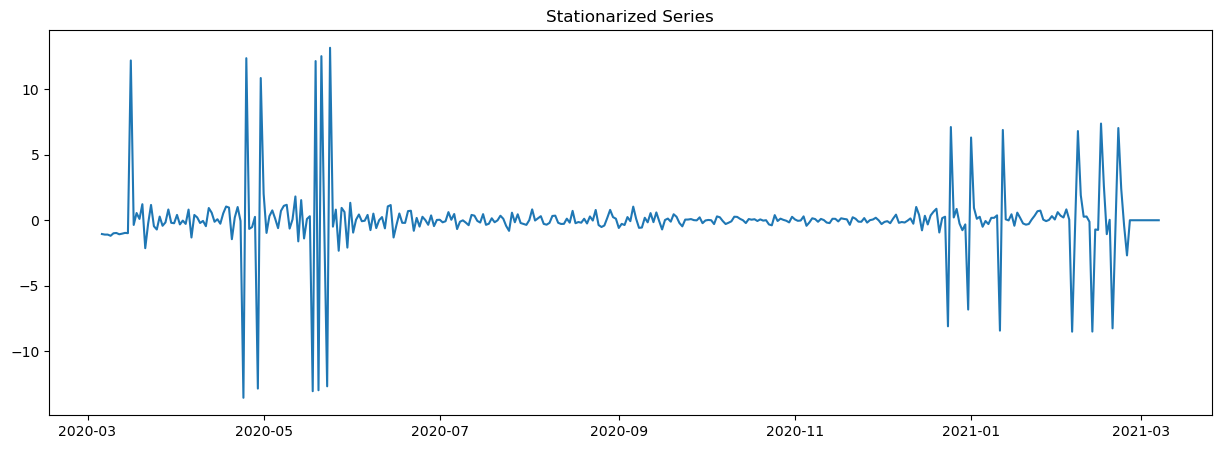

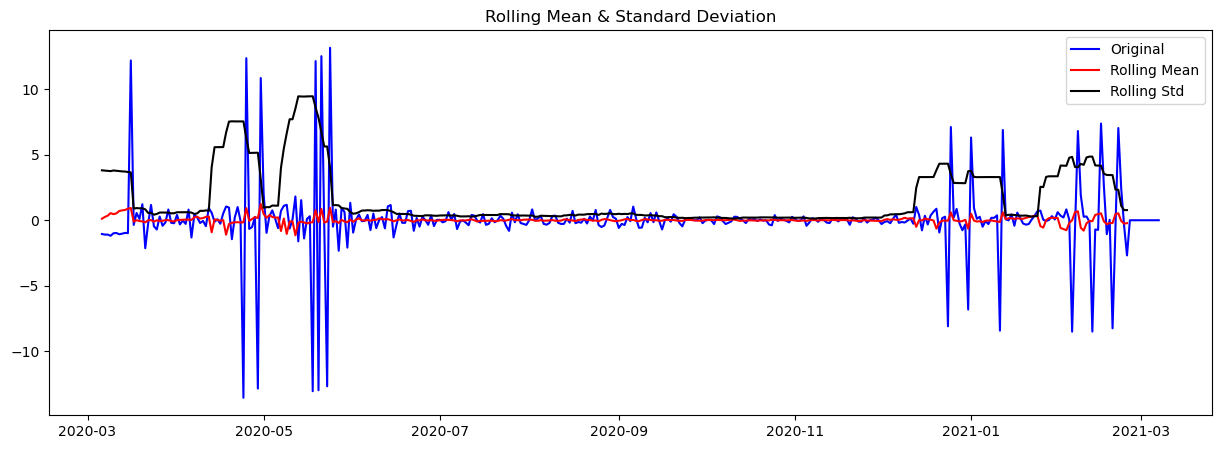

Results of Dickey-Fuller Test:
Test Statistic                -7.782857e+00
p-value                        8.327707e-12
#Lags Used                     1.700000e+01
Number of Observations Used    3.490000e+02
Critical Value (1%)           -3.449227e+00
Critical Value (5%)           -2.869857e+00
Critical Value (10%)          -2.571201e+00
dtype: float64

Results of KPSS Test:
Test Statistic            0.031162
p-value                   0.100000
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [43]:
stationarizedSeries = stationarizing(AlaskaTS)
test_stationarity(stationarizedSeries)

##### Since the Test Statistic is smaller than all critical values(even 1% critical value), we can say with 99% confidence that the series is stationary now.
##### Hence, we have obtained a stationary series on which we can fit the ARIMA model.

#### iv. Finding the best fit parameters for the ARIMA model

> ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is a regressive equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

>a. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable.

>b. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation.

>c. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. Thus, n=1.

In [44]:
from statsmodels.tsa.stattools import acf, pacf

###### function to find out parameters (p,q) of the ARIMA model:

In [45]:
def findParameters(ts_log_moving_avg_diff_diff):
    ts_log_moving_avg_diff_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
    ts_log_moving_avg_diff_diff= ts_log_moving_avg_diff_diff.replace(np.nan,0)
    lag_acf = acf(ts_log_moving_avg_diff_diff, nlags=20)
    lag_pacf = pacf(ts_log_moving_avg_diff_diff, nlags=20, method='ols')
    
    #Plot ACF:
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
    import statsmodels.api as sm
    result = {}
    for p in range(5):
        for q in range(5):
            arma = sm.tsa.ARIMA(ts_log_moving_avg_diff_diff, order=(p,0,q))
            arma_fit = arma.fit()
            result[(p,q)] = arma_fit.aic

    p,q = min(result, key=result.get)
    
    import warnings
    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

    
    return p,q

C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been pro

C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been pro

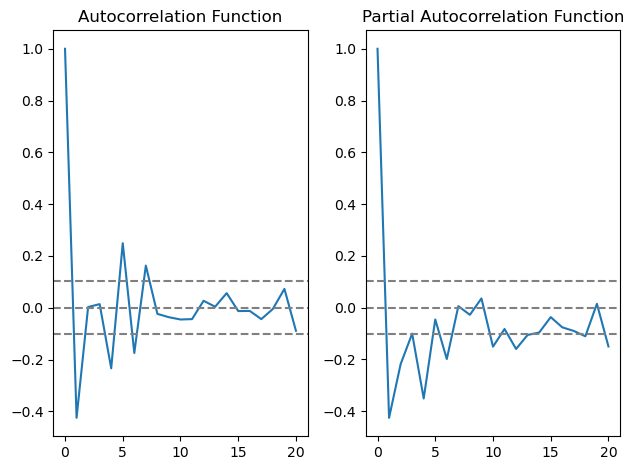

In [46]:
p,q=findParameters(stationarizedSeries)

###### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots:
>These plots can be used to manually spot potentially correct parameters:

>p : The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1. 

>q : The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.

#### We have also created a function that computes the parameters that yield the best fit ARIMA model for the chosen data.

In [47]:
print(p)
print(q)

2
4


#### v. Fitting the arima model 

##### Function to fit AR model 

In [48]:
def fitAR(ts_log_moving_avg_diff_diff, p, q):
    
    from statsmodels.tsa.arima_model import ARIMA
    f = plt.figure(figsize=(20,10))
    #AR MODEL
    model = ARIMA(ts_log_moving_avg_diff_diff, order=(p, 1, 0))  
    results_AR = model.fit(disp=-1)
    plt.plot(ts_log_moving_avg_diff_diff)
    plt.plot(results_AR.fittedvalues, color='red')
    results_AR.fittedvalues= results_AR.fittedvalues.replace(np.nan,0)
    ts_log_moving_avg_diff_diff= ts_log_moving_avg_diff_diff.replace(np.nan,0)
    
    plt.title('RSS: %.4f'% ((results_AR.fittedvalues-ts_log_moving_avg_diff_diff)**2).sum())
 
    return results_AR, results_AR.fittedvalues

In [49]:
def fitMA(ts_log_moving_avg_diff_diff, p, q):
    from statsmodels.tsa.arima_model import ARIMA
    f = plt.figure(figsize = (20,10))
    #MA MODEL
    model = ARIMA(ts_log_moving_avg_diff_diff, order=(0, 1, q))  
    results_MA = model.fit(disp=-1)  
    plt.plot(ts_log_moving_avg_diff_diff)
    plt.plot(results_MA.fittedvalues, color='red')
    results_MA.fittedvalues= results_MA.fittedvalues.replace(np.nan,0)
    ts_log_moving_avg_diff_diff= ts_log_moving_avg_diff_diff.replace(np.nan,0)
    
    plt.title('RSS: %.4f'% ((results_MA.fittedvalues-ts_log_moving_avg_diff_diff)**2).sum())
    
    return results_MA, results_MA.fittedvalues

###### Fitting AR model on stationarized series 

In [50]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming stationarizedSeries, p, and q are already defined
fitted_modelAR = ARIMA(stationarizedSeries, order=(p, 1, q)).fit()
fitted_valuesAR = fitted_modelAR.fittedvalues

print(fitted_modelAR.summary())
print(fitted_valuesAR)
print(stationarizedSeries)


C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

                                   SARIMAX Results                                   
Dep. Variable:     probabilityOfGettingCOVID   No. Observations:                  367
Model:                        ARIMA(2, 1, 4)   Log Likelihood                -801.608
Date:                       Mon, 27 Nov 2023   AIC                           1617.215
Time:                               13:42:49   BIC                           1644.534
Sample:                                    0   HQIC                          1628.071
                                       - 367                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8074      0.030    -59.646      0.000      -1.867      -1.748
ar.L2         -0.8429      0.025    -33.100      0.000      -0.893      -0.

###### Fitting MA model on stationarized series 

In [51]:
from statsmodels.tsa.arima.model import ARIMA

def fitMA(ts, p, q):
    # Fit an MA model to the time series 'ts'
    # Assuming the 'ts' is already differenced (if necessary), hence d=0 in the order
    model = ARIMA(ts, order=(0, 0, q))
    results_MA = model.fit()
    
    # The fitted values and model summary can be returned
    fitted_values_MA = results_MA.fittedvalues
    return results_MA, fitted_values_MA

# Assuming stationarizedSeries, p, and q are already defined
fitted_modelMA, fitted_valuesMA = fitMA(stationarizedSeries, p, q)

# Now you can print the summary of the fitted model
print(fitted_modelMA.summary())


C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

                                   SARIMAX Results                                   
Dep. Variable:     probabilityOfGettingCOVID   No. Observations:                  367
Model:                        ARIMA(0, 0, 4)   Log Likelihood                -797.981
Date:                       Mon, 27 Nov 2023   AIC                           1607.961
Time:                               13:42:50   BIC                           1631.394
Sample:                                    0   HQIC                          1617.272
                                       - 367                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.005      0.588      0.556      -0.007       0.013
ma.L1         -0.6866      0.188     -3.655      0.000      -1.055      -0.

C:\Users\saharsh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### vi. Testing Accuracy of fitted model

###### function to compute accuracy measures for the fitted model

>Mean Error (ME)

>Mean Absolute Error (MAE)

>Root Mean Squared Error (RMSE)

>Correlation between the Actual and the Forecast (corr)

In [52]:
def forecast_accuracy(forecast, actual):
   
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    return({'me':me, 'mae': mae, 
            'rmse':rmse,'corr':corr})

In [53]:
stationarizedDF= stationarizedSeries.to_frame()
stationarizedDF= stationarizedDF[1:]
stationarized= stationarizedDF.squeeze()

In [54]:

if len(fitted_valuesAR) != len(stationarized):
    # Find the length difference
    len_diff = abs(len(fitted_valuesAR) - len(stationarized))
    
    # Trim the longer series at the beginning to match lengths
    if len(fitted_valuesAR) > len(stationarized):
        fitted_valuesAR = fitted_valuesAR[len_diff:]
    else:
        stationarized = stationarized[len_diff:]

# Now the lengths should match and you can calculate the forecast accuracy
forecast_accuracy(fitted_valuesAR, stationarized)


{'me': -0.06669325003641097,
 'mae': 1.0853948821428656,
 'rmse': 2.1583544322567,
 'corr': 0.5837996336029865}

> As we can see, the RMSE value for the fitted model is quite low, implying that the fitted model is accurate for predicting future data.

#### vii. Predicting values for next 15 days 

In [55]:
#PREDICTING VALUES FOR NEXT 15 DAYS

def ARIMApredictions(state, value):
    
    stateDF=findProbability(StateWisePopulation,StatewiseData, state)
    stateDF= stateDF.iloc[::-1]
    stateDF = stateDF.reset_index(drop=True)


    k =stateDF[value].loc[:]
    state_value = k.values.tolist()
    d= stateDF['date'].loc[:]
    dates= d.to_list()
    data = pd.DataFrame(columns = ['ds','y'])
    data['ds'] = dates
    data['y'] =state_value
    
    
    #prediction
    
    arima = ARIMA(data['y'], order=(5, 1, 0))
    arima = arima.fit(trend='c', full_output=True, disp=True)
    forecast = arima.forecast(steps= 30)
    pred = list(forecast[0])

    start_date = data['ds'].max()
    prediction_dates = []
    for i in range(30):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date
    plt.figure(figsize= (15,9))
    plt.xlabel("Dates",fontsize = 20)
    plt.ylabel(value,fontsize = 20)
    plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

    plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
    plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
    plt.legend();
    
    return  

In [56]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import datetime

def ARIMApredictions(state, value):
    # ... (rest of your code to prepare 'data' DataFrame)

    #prediction
    arima_model = ARIMA(data['y'], order=(5, 1, 0), trend='c')
    arima_results = arima_model.fit()
    forecast = arima_results.forecast(steps=30)
    pred = list(forecast)

    start_date = pd.to_datetime(data['ds'].max())
    prediction_dates = [start_date + datetime.timedelta(days=i) for i in range(1, 31)]

    # Plotting code remains the same
    # ...

    return pred

# The user interface code remains the same
# ...


## User Interface

##### User Interaction Code to ask user for different combinations of states and values that we want to predict

In [64]:
StateList= CovidUseful['state'].unique().tolist()
index=range(1,len(StateList))
StateDict={}
for i in index: 
    StateDict[i]=StateList[i]
    
for number, state in StateDict.items(): 
    print(number+1, ":", state) 

print()
state=input("Enter the state you wish to get predictions for: ")
print()
print("Possible values to predict for next 15 days:")
print()
print("1. positive: Total confirmed and probable cases in the state")
print("2. recovered: Total number of people who have recovered from COVID in the state")
print("3. death: Total number of confirmed and probable deaths due to COVID in the state")
print("4. hospitalizedCumulative: Total number of people who have been hospitalized due to COVID in the state")
print("5. inIcuCumulative: Total number of people who have been in ICU due to COVID in the state")
print("6. onVentilatorCumulative: Total number of people who have been on ventilator due to COVID in the state")
print("7. immunisedPopulation: Total number of people who who have antibodies currently i.e. immune to infection")
print("8. activeCases: Total number of people who currently have COVID in the state")
print("9. probabilityOfGettingCOVID: Probability of a person getting COVID on a particular day in the state")
print()
value=input("Enter the value you want to predict for the next 15 days: ")

2 : AL
3 : AR
4 : AS
5 : AZ
6 : CA
7 : CO
8 : CT
9 : DC
10 : DE
11 : FL
12 : GA
13 : GU
14 : HI
15 : IA
16 : ID
17 : IL
18 : IN
19 : KS
20 : KY
21 : LA
22 : MA
23 : MD
24 : ME
25 : MI
26 : MN
27 : MO
28 : MP
29 : MS
30 : MT
31 : NC
32 : ND
33 : NE
34 : NH
35 : NJ
36 : NM
37 : NV
38 : NY
39 : OH
40 : OK
41 : OR
42 : PA
43 : PR
44 : RI
45 : SC
46 : SD
47 : TN
48 : TX
49 : UT
50 : VA
51 : VI
52 : VT
53 : WA
54 : WI
55 : WV
56 : WY

Enter the state you wish to get predictions for: WY

Possible values to predict for next 15 days:

1. positive: Total confirmed and probable cases in the state
2. recovered: Total number of people who have recovered from COVID in the state
3. death: Total number of confirmed and probable deaths due to COVID in the state
4. hospitalizedCumulative: Total number of people who have been hospitalized due to COVID in the state
5. inIcuCumulative: Total number of people who have been in ICU due to COVID in the state
6. onVentilatorCumulative: Total number of people wh

In [65]:
def ARIMApredictions(state, value):
    # Your existing code to prepare stateDF
    # ...
    
    # Ensure that 'state_value' is a list of numbers and 'dates' is a list of dates
    assert isinstance(state_value, list) and all(isinstance(x, (int, float)) for x in state_value), "state_value must be a list of numbers"
    assert isinstance(dates, list) and all(isinstance(x, pd.Timestamp) for x in dates), "dates must be a list of pd.Timestamp"

    # Now create the DataFrame
    data = pd.DataFrame({
        'ds': dates,
        'y': state_value
    })

    # Check if 'y' column exists
    if 'y' not in data:
        raise KeyError("'y' column not found in data DataFrame.")

    # Rest of your code...
    # ...


In [66]:
def ARIMApredictions(state, value):
    stateDF = findProbability(StateWisePopulation, StatewiseData, state)
    stateDF = stateDF.iloc[::-1]
    stateDF = stateDF.reset_index(drop=True)

    # Make sure 'value' is the name of the column you want to predict. 
    # This column should exist in stateDF DataFrame.
    state_value = stateDF[value].tolist()
    dates = pd.to_datetime(stateDF['date']).tolist()  # Ensure the 'date' column is converted to datetime

    data = pd.DataFrame({
        'ds': dates,
        'y': state_value
    })

    # Now that 'state_value' is defined, you can use it
    # Proceed with fitting the ARIMA model
    arima_model = ARIMA(data['y'], order=(5, 1, 0))
    arima_results = arima_model.fit()

Average growth factor 1.0277337463990446


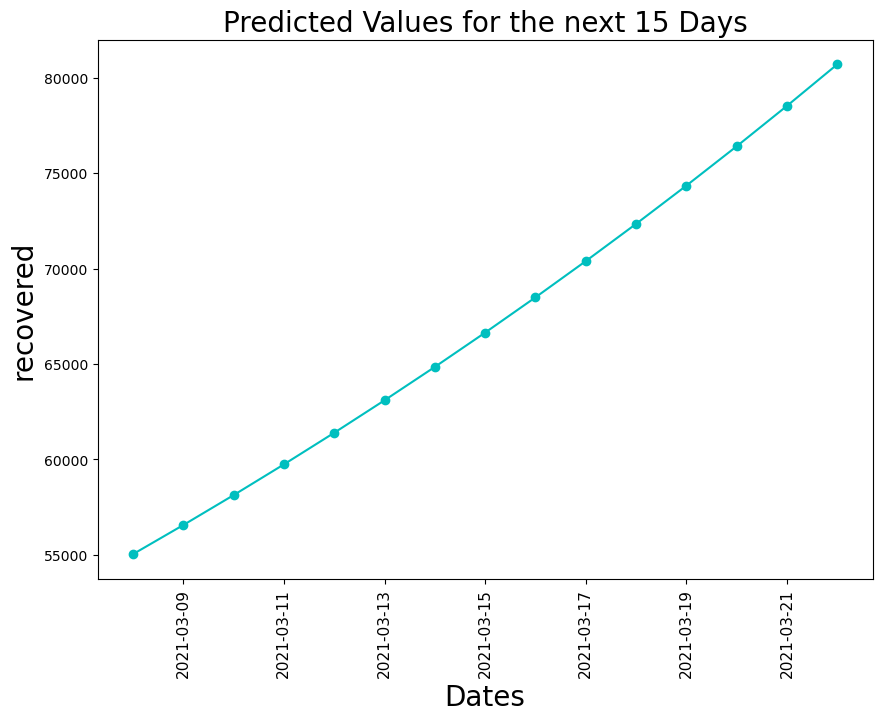

In [67]:
averageGrowthFactorPrediction(state, value)
ARIMApredictions(state, value)

## Hence i have successfully been able to predict useful information regarding the pandemic for the short future 

## Practiced by kolluru saharsh